# Comparing Scores for tigge, deterministic, parametric, test-time dropout, categorical models

Todo
- run scripts for MC dropout
- in parametric, std values negative in 0.01% cases. ->make them zero.
- in categorical, 
    - instead of mean=sigma(xP), try sampling to find scores
    - see why quantile binning giving worse results than uniform
    - check if making first, last bin_edges uniform increases score.(minor thing.may skip)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

In [4]:
#if model was trained on mixed precision policy, loading on the same policy necessary? Yes. see verbose results of model.predict
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [9]:
# model_save_dir='/home/garg/data/WeatherBench/predictions_P/saved_models'
# datadir='/home/garg/data/WeatherBench/5.625deg'
# pred_save_dir='/home/garg/data/WeatherBench/predictions_P'
model_save_dir='/home/rasp/data/myWeatherBench/predictions_P/saved_models/'
datadir='/data/stephan/WeatherBench/5.625deg/'
pred_save_dir='/home/rasp/data/myWeatherBench/predictions_P/'


In [77]:
#Parameters
lead_time=72
members=50

In [7]:
!ls $pred_save_dir

001-resnet_d3_ztt_3d_dr0.0_m50.nc  009-resnet_d3_tp_3d_cat.nc
001-resnet_d3_ztt_3d_dr0.0.nc	   010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m50.nc  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	   012-resnet_d3_t2m_3d_cat_quant.nc
004-resnet_d3_ztt_3d_dr0.5_m50.nc  013-resnet_d3_tp_3d_cat_quant.nc
004-resnet_d3_ztt_3d_dr0.5_m5.nc   017-resnet_d3_ztt_3d_m50.nc
004-resnet_d3_ztt_3d_dr0.5.nc	   020-resnet_d3_tp_3d_dr0.0_m50.nc
005.1-resnet_d3_ztt_3d_param.nc    020-resnet_d3_tp_3d_dr0.0.nc
005-resnet_d3_ztt_3d_param.nc	   021-resnet_d3_tp_3d_dr0.2_m50.nc
006.1-resnet_d3_z_3d_cat.nc	   021-resnet_d3_tp_3d_dr0.2.nc
006-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m50.nc
007.1-resnet_d3_t_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m5.nc
0078resnet_d3_t2m_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5.nc
007-resnet_d3_t_3d_cat.nc	   054-resnet_d3_tp_3d_m50.nc
008.1-resnet_d3_t2m_3d_cat.nc	   saved_models


## Data

In [8]:
!ls {datadir}

24hr_precipitation    geopotential	   temperature_850
2m_temperature	      geopotential_500	   toa_incident_solar_radiation
2m_temperature_daily  potential_vorticity  total_precipitation
6hr_precipitation     specific_humidity    u_component_of_wind
constants	      temperature	   v_component_of_wind


In [10]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

# SR: Not necessary because we never look at other levels
ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid])  #.rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(341880, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(341880, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

## TIGGE - Precip still missing

In [10]:
tigge_dir = '/mnt/netdisk1/stephan/WeatherBench/tigge/5.625deg/'

In [11]:
!ls $tigge_dir

2m_temperature_ens    temperature_850	   total_precipitation_ens
geopotential_500      temperature_850_ens  total_precipitation_ens_old
geopotential_500_ens  total_precipitation


In [12]:
tigge_z = xr.open_mfdataset(f'{tigge_dir}geopotential_500_ens/*nc')
tigge_t = xr.open_mfdataset(f'{tigge_dir}temperature_850_ens/*nc')
tigge_t2m = xr.open_mfdataset(f'{tigge_dir}2m_temperature_ens/*nc')
# tigge_tp = xr.open_mfdataset(f'{tigge_dir}total_precipitation_ens/*nc')

In [13]:
# Covert to ERA convention
tigge_z *= 9.806

In [14]:
# TODO Precipitation

In [15]:
tigge = xr.merge([tigge_z, tigge_t, tigge_t2m], compat="override")

In [16]:
tigge = tigge.rename({'number': 'member', 'gh':'z'})
tigge = tigge.sel(step='3 days')
tigge['time'] = tigge['valid_time']

In [17]:
tigge = tigge.sel(time=slice('2017', '2018'))

In [18]:
tigge.load()

<xarray.Dataset>
Dimensions:            (lat: 32, lon: 64, member: 50, time: 1454)
Coordinates:
    step               timedelta64[ns] 3 days
  * time               (time) datetime64[ns] 2017-01-04 ... 2018-12-31T12:00:00
    isobaricInhPa      int64 500
    valid_time         (time) datetime64[ns] 2017-01-04 ... 2018-12-31T12:00:00
  * lon                (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat                (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * member             (member) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    heightAboveGround  int64 2
Data variables:
    z                  (member, time, lat, lon) float32 51355.71 ... 48772.332
    t                  (member, time, lat, lon) float32 258.87042 ... 248.53922
    t2m                (member, time, lat, lon) float32 246.63593 ... 248.03877

### RMSE of ensemble mean

In [19]:
tigge_rmse = compute_weighted_rmse(tigge.mean('member'), valid).load()

/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
tigge_rmse

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
Data variables:
    z                  float64 144.8
    t                  float64 1.201
    t2m                float64 1.257

In [21]:
tigge_rmse.to_netcdf('/tmp/tigge_rmse.nc')

### Spread-skill

In [22]:
tigge_spreadskill=compute_weighted_meanspread(tigge)/tigge_rmse
tigge_spreadskill

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
Data variables:
    z                  float64 1.051
    t                  float64 0.9288
    t2m                float64 0.6881

In [23]:
tigge_spreadskill.to_netcdf('/tmp/tigge_spreadskill.nc')

### CRPS

In [24]:
tigge_crps=compute_weighted_crps(tigge, valid[['z', 't', 't2m']].sel(time=tigge.time))
tigge_crps.load()

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
Data variables:
    z                  float64 65.6
    t                  float64 0.5994
    t2m                float64 0.5755

In [25]:
tigge_crps.to_netcdf('/tmp/tigge_crps.load.nc')

### Rank histogram - TODO

In [82]:
from ranky import rankz
from scipy.stats import rankdata
import pdb

def rankz_weighted(obs, ensemble, weights_lat, density=False):
    shape = obs.shape
    obs = obs.reshape(-1)
    ensemble = ensemble.reshape(ensemble.shape[0], -1)
    
    combined=np.vstack((obs[np.newaxis],ensemble))
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)
    
    #ToDo: not sure if this ties-part works for ndarray. but minor thing.
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    has_tie = np.argwhere(ties > 0).squeeze()

    for i in has_tie:
#         print('Tie', ranks[i], ensemble[:, i], obs[i])
        min_rank = ranks[i]
        max_rank = ranks[i] + ties[i]
        ranks[i] = np.random.randint(min_rank, max_rank)
    
    ranks = ranks.reshape(shape)
    
    weights=np.ones(ranks.shape)
    weights=weights*weights_lat[np.newaxis,:,np.newaxis]

    return np.histogram(ranks, bins=np.linspace(0.5, combined.shape[0]+0.5, combined.shape[0]+1),
                       weights=weights, density=density)

In [27]:
weights_lat = np.cos(np.deg2rad(valid.lat))
weights_lat /= weights_lat.mean()

In [28]:
ranks = {}
for v in tigge:
    print(v)
    time = tigge.time[:5]
    p = tigge[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)

    ranks[v] = rank

z
t
t2m


In [29]:
with open(f'tmp/tigge_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

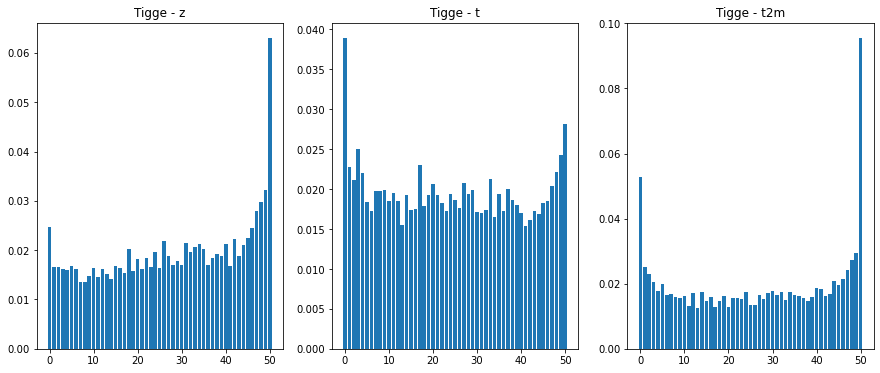

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Tigge - {v}')

Uncalibrated, probably simple bias.

## Monte-carlo dropout

In [31]:
pred_save_dir_dr='/home/rasp/data/myWeatherBench/predictions_'

mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'C/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'C/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

### Load and evaluate no-dropout predictions

In [32]:
rmses, maes = [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i]+'.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i]+'.nc')
    preds = xr.merge([preds_ztt, preds_tp]).isel(time=slice(0, None, 12))
    rmse = compute_weighted_rmse(preds, valid).load()
    rmses.append(rmse)
    mae = compute_weighted_mae(preds, valid).load()
    maes.append(mae)

4it [00:24,  6.17s/it]


In [33]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
rmses

<xarray.Dataset>
Dimensions:     (concat_dim: 4)
Coordinates:
  * concat_dim  (concat_dim) float64 0.0 0.1 0.2 0.5
Data variables:
    t2m         (concat_dim) float64 1.606 1.528 1.598 1.866
    z           (concat_dim) float64 351.5 313.7 323.0 376.2
    t           (concat_dim) float64 1.931 1.793 1.854 2.109
    tp          (concat_dim) float64 0.002278 0.002216 0.002217 0.002259

In [34]:
rmses.to_netcdf('tmp/dropout_det_rmse.nc')
maes.to_netcdf('tmp/dropout_det_mae.nc')

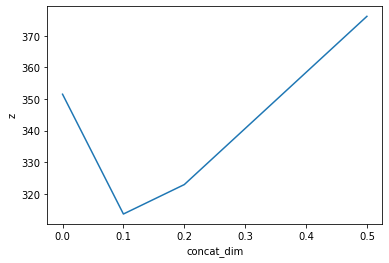

In [35]:
rmses.z.plot();

### Create 50 member dropout predictions

SR: Only predicting every 12th time step. Makes very little difference for score and is 12 times faster. You should be able to do this on PC as well. For me this takes around 4 minutes.

Note: Manually change P to C for 0.1 exps.

In [46]:
for e in mc_exp_ids_ztt:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12'
    print(s)

python create_dropout_ensemble.py  50  ../nn_configs/P/001-resnet_d3_ztt_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/C/017-resnet_d3_ztt_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/003-resnet_d3_ztt_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --

In [49]:
for e in mc_exp_ids_tp:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12'
    print(s)

python create_dropout_ensemble.py  50  ../nn_configs/P/020-resnet_d3_tp_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/C/054-resnet_d3_tp_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/021-resnet_d3_tp_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data

### Compute RMSE of ensemble mean and spread/skill and CRPS

In [36]:
members = 50

In [37]:
mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'P/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'P/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

In [39]:
rmses, maes, crpss, spread_skills = [], [], [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    ens_mean = preds.mean('member')
    rmse = compute_weighted_rmse(ens_mean, valid).load()
    mae = compute_weighted_mae(ens_mean, valid).load()
    crps = compute_weighted_crps(preds, valid).load()
    spread = compute_weighted_meanspread(preds).load()
    rmses.append(rmse)
    maes.append(mae)
    crpss.append(crps)
    spread_skills.append(spread / rmse)

4it [01:35, 23.81s/it]


In [40]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
crpss = xr.concat(crpss, dim=[0, 0.1, 0.2, 0.5])
spread_skills = xr.concat(spread_skills, dim=[0, 0.1, 0.2, 0.5])

In [41]:
rmses.to_netcdf('tmp/dropout_rmse.nc')
maes.to_netcdf('tmp/dropout_mae.nc')
crpss.to_netcdf('tmp/dropout_crps.nc')
spread_skills.to_netcdf('tmp/dropout_spreadskill.nc')

In [42]:
rmses = xr.open_dataset('tmp/dropout_rmse.nc')
maes = xr.open_dataset('tmp/dropout_mae.nc')
crpss = xr.open_dataset('tmp/dropout_crps.nc')
spread_skills = xr.open_dataset('tmp/dropout_spreadskill.nc')

In [43]:
crpss[['z', 't', 't2m', 'tp']].isel(concat_dim=3).load()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    concat_dim  float64 0.5
Data variables:
    z           float64 243.6
    t           float64 1.504
    t2m         float64 1.12
    tp          float64 0.0006331

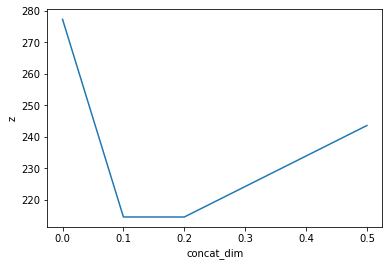

In [44]:
crpss.z.plot()

### Rank histogram

In [48]:
ranks = {}
for i, dr in tqdm(enumerate([0.1, 0.2, 0.5])):
    ranks[dr] = {}
    print(dr)
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i+1]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i+1]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    for v in preds:
        print(v)
        time = preds.time[:5]
        p = preds[v].sel(time=time)
        o = valid[v].sel(time=time).load()
        rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
        ranks[dr][v] = rank

0it [00:00, ?it/s]

0.1
t2m
z
t
tp


1it [00:06,  6.14s/it]

0.2
z
t
t2m
tp


2it [00:12,  6.12s/it]

0.5
t2m
z
t
tp


3it [00:18,  6.09s/it]


In [49]:
with open(f'tmp/dropout_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

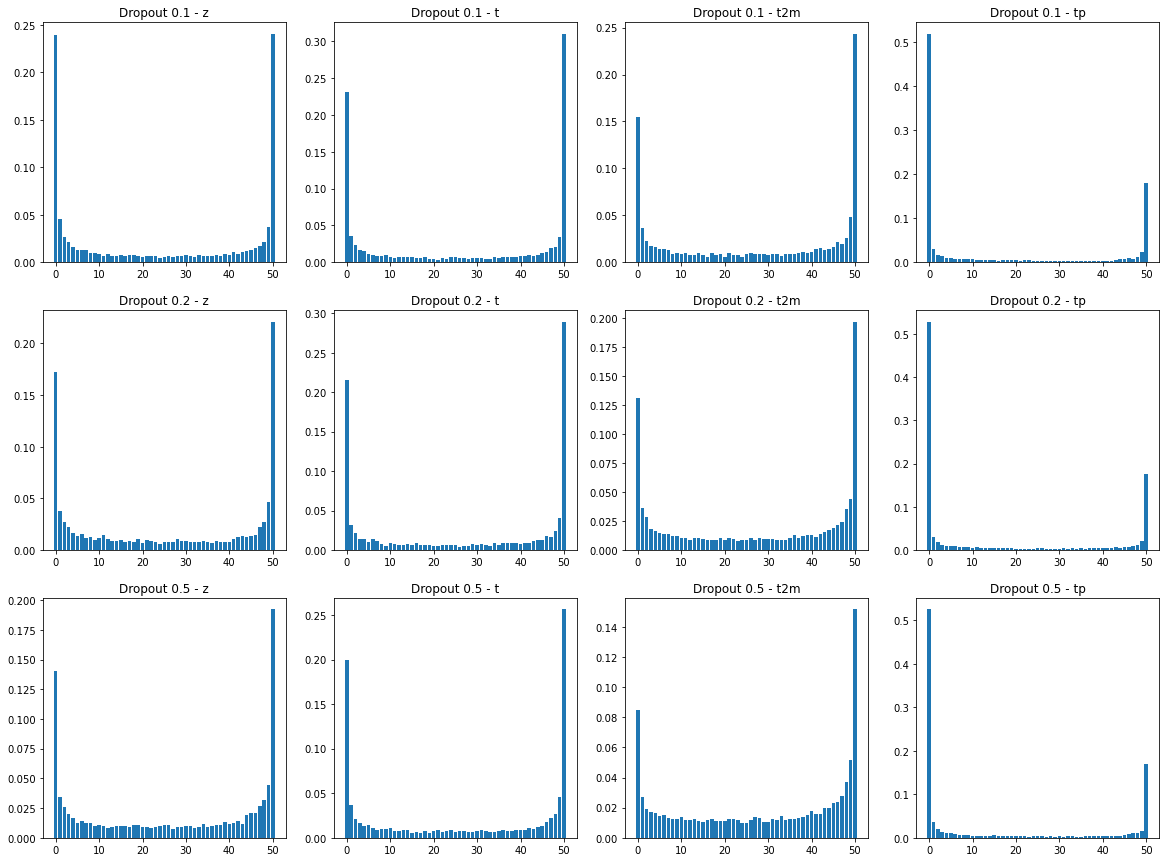

In [50]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, dr in enumerate([0.1, 0.2, 0.5]):
    for j, v in enumerate(['z', 't', 't2m', 'tp']):
        r = ranks[dr][v]
        axs[i, j].bar(np.arange(51), r[0])
        axs[i, j].set_title(f'Dropout {dr} - {v}')

## Parametric - tp missing

In [53]:
preds_ztt = xr.open_dataset(f'{pred_save_dir}/005.1-resnet_d3_ztt_3d_param.nc')

In [54]:
preds_ztt_mean=preds_ztt[['z-mean','t-mean','t2m-mean']].rename({'z-mean':'z','t-mean':'t','t2m-mean':'t2m'})
preds_ztt_std=preds_ztt[['z-std','t-std','t2m-std']].rename({'z-std':'z','t-std':'t','t2m-std':'t2m'})

In [55]:
preds_ztt_std = preds_ztt_std.where(preds_ztt_std>0, 1e-7)  # To avoid division by zero in CRPS

### RMSE of ensemble mean

In [56]:
rmse = compute_weighted_rmse(preds_ztt_mean, valid).compute()
rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 315.3
    t        float64 1.818
    t2m      float64 1.549

In [57]:
rmse.to_netcdf('tmp/parametric_rmse.nc')

### Spread skill

In [58]:
var = preds_ztt_std**2

In [59]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [60]:
spread= np.sqrt((var*weights_lat).mean())

In [61]:
spread_skill = spread / rmse

In [62]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.8716
    t        float64 0.9208
    t2m      float64 0.9462

In [63]:
spread_skill.to_netcdf('tmp/parametric_spreadskill.nc')

### CRPS

In [64]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[: , None, None]).mean(mean_dims)
    return crps

In [66]:
crps = compute_weighted_crps_gaussian(valid.isel(time=slice(0, None, 12))[['z', 't', 't2m']], preds_ztt_mean, preds_ztt_std).load()
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 142.7
    t        float64 0.9016
    t2m      float64 0.7037

In [67]:
crps.to_netcdf('tmp/parametric_crps.nc')

### Rank histogram

In [68]:
members

50

In [433]:
das = []
for v in preds_ztt_mean:
    da = xr.DataArray(
        np.random.normal(
            preds_ztt_mean[v].values, 
            preds_ztt_std[v].values,
            size=(members, *preds_ztt_mean[v].shape)
        ),
        coords={
            'member': np.arange(members),
            'time': preds_ztt_mean.time,
            'lat': preds_ztt_mean.lat, 
            'lon': preds_ztt_mean.lon,}, 
        dims=['member','time','lat', 'lon'],
        name=v
    )
    das.append(da)
preds_ztt_ens = xr.merge(das)

In [437]:
preds_ztt_ens.to_netcdf('tmp/preds_param_ztt_ens.nc')

In [69]:
preds_ztt_ens = xr.open_dataset('tmp/preds_param_ztt_ens.nc')

In [70]:
ranks = {}
for v in preds_ztt_ens:
    print(v)
    time = preds_ztt_ens.time[:5]
    p = preds_ztt_ens[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

z
t
t2m


In [71]:
with open(f'tmp/parametric_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

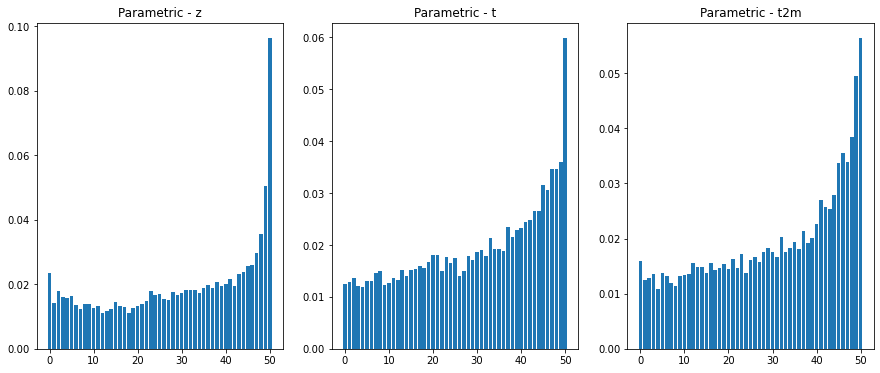

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

## Categorical

In [11]:
valid_diff = (valid.shift() -  valid.shift(time=lead_time)).isel(time=slice(0, None, 12))

In [12]:
valid_diff['tp'] = valid['tp']

In [13]:
valid_diff

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 29220)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(28490, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(28490, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>

In [91]:
valid_diff['tp'] = np.maximum(0, valid_diff.tp)

In [14]:
preds_cat = xr.merge([
    xr.open_dataset(f'{pred_save_dir}/006.1-resnet_d3_z_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/007.1-resnet_d3_t_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/008.1-resnet_d3_t2m_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/009-resnet_d3_tp_3d_cat.nc'),
]).isel(time=slice(0, None, 12))

In [15]:
preds_cat

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 ...
    t        (time, lat, lon, bin) float32 ...
    t2m      (time, lat, lon, bin) float32 ...
    tp       (time, lat, lon, bin) float32 ...

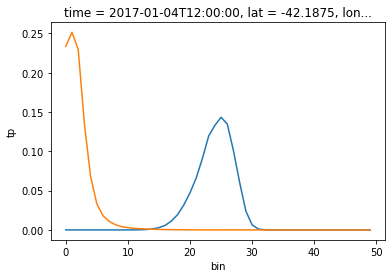

In [16]:
time = '2017-01-04T12:00:00'
preds_cat.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [18]:
def log_retrans(x, e):
    return np.exp(x + np.log(e)) - e

In [19]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m']:
    preds_cat[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2

v='tp'
preds_cat[v].bin_edges[:] = log_retrans(preds_cat[v].bin_edges, 0.001)
preds_cat[v].bin_edges[0] = 0
preds_cat[v].bin_edges[-1] = valid[v].max().values
preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2
preds_cat[v].mid_points[0] = 0

### RMSE of mean

In [20]:
means = []
for v in preds_cat:
    means.append((preds_cat[v] * preds_cat[v].mid_points).sum('bin'))
means = xr.merge(means)

In [21]:
rmse_cat = compute_weighted_rmse(means, valid_diff).load()

In [22]:
rmse_cat

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 327.5
    t        float64 1.802
    t2m      float64 1.492
    tp       float64 0.002173

In [23]:
rmse_cat.to_netcdf('tmp/categorical_rmse.nc')

### Spread/skill ratio

In [24]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
meansquares = []
for v in preds_cat:
    meansquares.append((preds_cat[v] * preds_cat[v].mid_points**2).sum('bin'))
meansquares = xr.merge(meansquares)

In [25]:
var = meansquares - means**2

In [26]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [27]:
spread = np.sqrt((var*weights_lat).mean())

In [28]:
spread_skill = spread / rmse_cat

In [29]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.9068
    t        float64 0.9421
    t2m      float64 0.9807
    tp       float64 1.238

In [30]:
spread_skill.to_netcdf('tmp/categorical_spreadskill.nc')

### CRPS

In [31]:
crps = compute_weighted_bin_crps(preds_cat, valid_diff)

100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


In [32]:
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 142.6
    t        float64 0.8659
    t2m      float64 0.6479
    tp       float64 0.0004715

In [33]:
crps.to_netcdf('tmp/categorical_crps.nc')

### Rank histogram

In [71]:
time = preds_cat.time[:5]

In [72]:
def rand_choice(p, mid_points=None):
    p = p / p.sum()
    return np.random.choice(mid_points, size=1, p=p, replace=True)

In [78]:
das = []
for v in preds_cat:
    da = preds_cat[v].sel(time=time)
    da = xr.concat([xr.apply_ufunc(
        rand_choice, da, kwargs={'mid_points': da.mid_points}, input_core_dims=[['bin']], vectorize=True
    )  for i in range(members)], 'member')
    das.append(da)
preds_cat_ens = xr.merge(das)

In [79]:
preds_cat_ens

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 50, time: 5)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-06T12:00:00
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Dimensions without coordinates: member
Data variables:
    z        (member, time, lat, lon) float64 -501.2 -100.2 ... 300.7 -300.7
    t        (member, time, lat, lon) float64 -1.422 -0.4738 ... 5.212 4.265
    t2m      (member, time, lat, lon) float64 -1.891 0.6302 ... -3.151 1.891
    tp       (member, time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [80]:
preds_cat_ens.to_netcdf('tmp/preds_cat_ens.nc')

In [93]:
ranks = {}
for v in preds_cat_ens:
    print(v)
    time = preds_cat_ens.time[:5]
    p = preds_cat_ens[v].sel(time=time)
    o = valid_diff[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

z
t
t2m
tp


In [94]:
with open(f'tmp/categorical_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

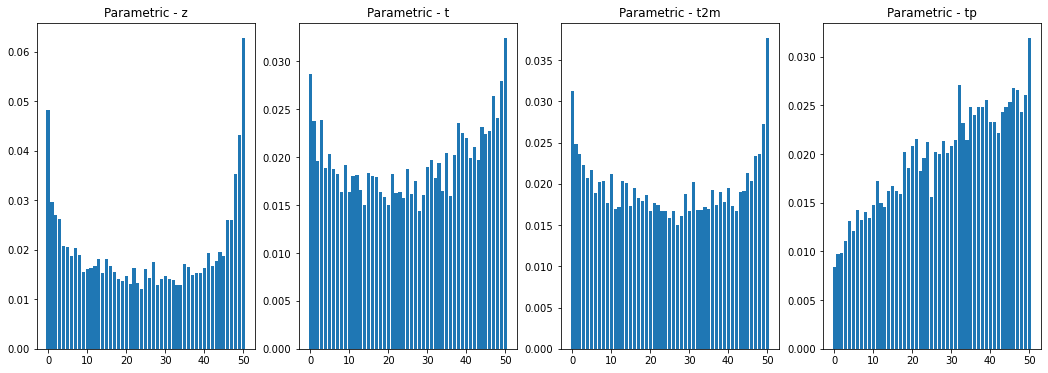

In [95]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

## Quantile-bins categorical

In [97]:
preds_cat_quant = xr.merge([
    xr.open_dataset(f'{pred_save_dir}/010-resnet_d3_z_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/011-resnet_d3_t_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/012-resnet_d3_t2m_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/013-resnet_d3_tp_3d_cat_quant.nc'),
]).isel(time=slice(0, None, 12))

In [99]:
preds_cat_quant

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 ...
    t        (time, lat, lon, bin) float32 ...
    t2m      (time, lat, lon, bin) float32 ...
    tp       (time, lat, lon, bin) float32 ...

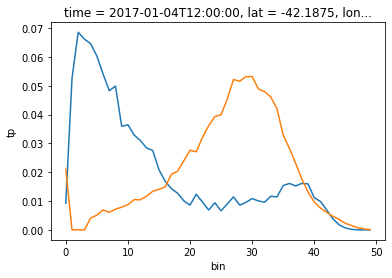

In [101]:
time = '2017-01-04T12:00:00'
preds_cat_quant.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat_quant.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [102]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m', 'tp']:
    preds_cat_quant[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat_quant[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat_quant[v].mid_points[:] = (preds_cat_quant[v].bin_edges[1:] +  preds_cat_quant[v].bin_edges[:-1])/2

(array([1.01086e+05, 5.56000e+02, 1.76000e+02, 1.02000e+02, 8.70000e+01,
        5.70000e+01, 6.20000e+01, 6.00000e+01, 8.10000e+01, 1.33000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

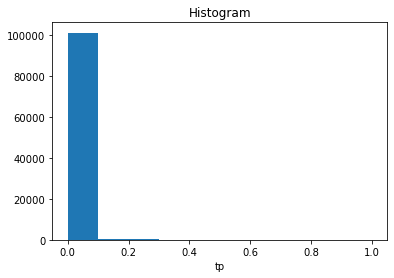

In [109]:
preds_cat_quant.tp.isel(time=0).plot()

### RMSE of mean

In [113]:
means = []
for v in preds_cat_quant:
    means.append((preds_cat[v] * preds_cat[v].mid_points).sum('bin'))
means = xr.merge(means)

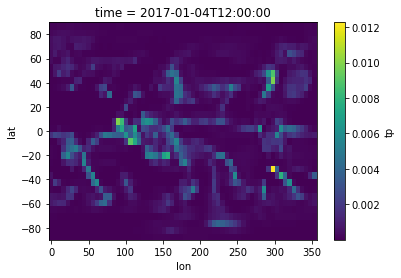

In [114]:
means.tp.isel(time=0).plot()

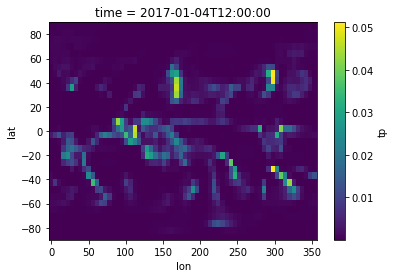

In [110]:
means.tp.isel(time=0).plot()

In [106]:
rmse_cat = compute_weighted_rmse(means, valid_diff).load()

In [107]:
rmse_cat

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 461.3
    t        float64 2.319
    t2m      float64 2.592
    tp       float64 0.006087

In [108]:
rmse_cat.to_netcdf('tmp/categorical_quantile_rmse.nc')

### Spread/skill ratio

In [24]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
meansquares = []
for v in preds_cat:
    meansquares.append((preds_cat[v] * preds_cat[v].mid_points**2).sum('bin'))
meansquares = xr.merge(meansquares)

In [25]:
var = meansquares - means**2

In [26]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [27]:
spread = np.sqrt((var*weights_lat).mean())

In [28]:
spread_skill = spread / rmse_cat

In [29]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.9068
    t        float64 0.9421
    t2m      float64 0.9807
    tp       float64 1.238

In [30]:
spread_skill.to_netcdf('tmp/categorical_spreadskill.nc')

### CRPS

In [31]:
crps = compute_weighted_bin_crps(preds_cat, valid_diff)

100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


In [32]:
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 142.6
    t        float64 0.8659
    t2m      float64 0.6479
    tp       float64 0.0004715

In [33]:
crps.to_netcdf('tmp/categorical_crps.nc')

### Rank histogram

In [71]:
time = preds_cat.time[:5]

In [72]:
def rand_choice(p, mid_points=None):
    p = p / p.sum()
    return np.random.choice(mid_points, size=1, p=p, replace=True)

In [78]:
das = []
for v in preds_cat:
    da = preds_cat[v].sel(time=time)
    da = xr.concat([xr.apply_ufunc(
        rand_choice, da, kwargs={'mid_points': da.mid_points}, input_core_dims=[['bin']], vectorize=True
    )  for i in range(members)], 'member')
    das.append(da)
preds_cat_ens = xr.merge(das)

In [79]:
preds_cat_ens

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 50, time: 5)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-06T12:00:00
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Dimensions without coordinates: member
Data variables:
    z        (member, time, lat, lon) float64 -501.2 -100.2 ... 300.7 -300.7
    t        (member, time, lat, lon) float64 -1.422 -0.4738 ... 5.212 4.265
    t2m      (member, time, lat, lon) float64 -1.891 0.6302 ... -3.151 1.891
    tp       (member, time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [80]:
preds_cat_ens.to_netcdf('tmp/preds_cat_ens.nc')

In [93]:
ranks = {}
for v in preds_cat_ens:
    print(v)
    time = preds_cat_ens.time[:5]
    p = preds_cat_ens[v].sel(time=time)
    o = valid_diff[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

z
t
t2m
tp


In [94]:
with open(f'tmp/categorical_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

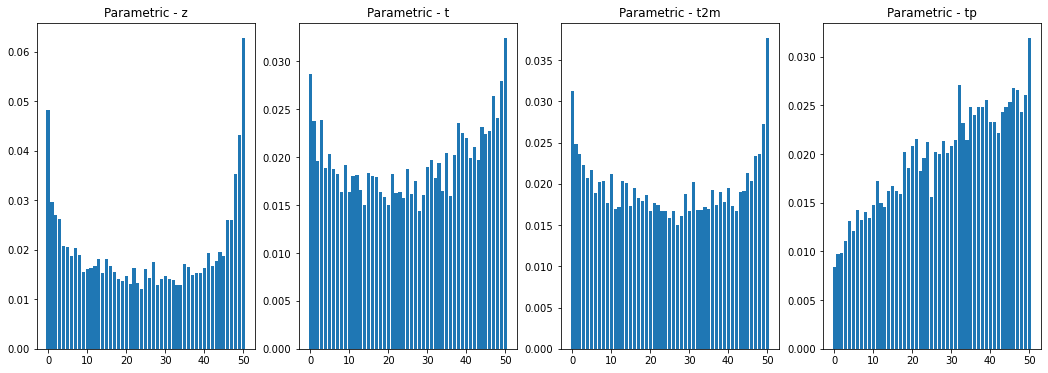

In [95]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

# Old

In [24]:
preds_cat_quant

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 ...
    t        (time, lat, lon, bin) float32 ...
    t2m      (time, lat, lon, bin) float32 ...

In [312]:
preds_cat_quant.z.mid_points

array([          -inf, -2262.90819448, -1905.94275062, -1658.69273963,
       -1447.47462874, -1267.35939278, -1108.52931242,  -957.88672279,
        -828.527322  ,  -720.45703522,  -627.12695533,  -548.5331986 ,
        -479.75976529,  -419.16797222,  -363.49805428,  -316.01953567,
        -273.44922447,  -232.52305109,  -196.49961179,  -167.01562922,
        -140.8144552 ,  -116.25390622,   -93.33203109,   -73.68359191,
         -55.67187381,   -37.66015572,   -21.2851556 ,    -4.91015587,
          13.09960947,    32.74609317,    54.03320153,    80.23242123,
         111.34375074,   149.00586077,   194.85546774,   248.89257789,
         309.47461186,   373.33398728,   440.46874986,   512.50975308,
         592.73825947,   682.79687328,   794.14452641,   928.41562   ,
        1080.69689281,  1257.53750094,  1468.7640664 ,  1730.74216008,
        2109.47751819,            inf])

In [311]:
preds_cat.z.bin_edges

array([          -inf, -4811.67512001, -4611.18865667, -4410.70219334,
       -4210.21573001, -4009.72926667, -3809.24280334, -3608.75634   ,
       -3408.26987667, -3207.78341334, -3007.29695   , -2806.81048667,
       -2606.32402334, -2405.83756   , -2205.35109667, -2004.86463334,
       -1804.37817   , -1603.89170667, -1403.40524334, -1202.91878   ,
       -1002.43231667,  -801.94585333,  -601.45939   ,  -400.97292667,
        -200.48646333,     0.        ,   200.48646333,   400.97292667,
         601.45939   ,   801.94585333,  1002.43231667,  1202.91878   ,
        1403.40524334,  1603.89170667,  1804.37817   ,  2004.86463334,
        2205.35109667,  2405.83756   ,  2606.32402334,  2806.81048667,
        3007.29695   ,  3207.78341334,  3408.26987667,  3608.75634   ,
        3809.24280334,  4009.72926667,  4210.21573001,  4410.70219334,
        4611.18865667,  4811.67512001,            inf])

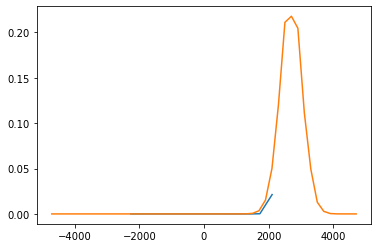

In [33]:
plt.plot(preds_cat_quant.z.mid_points, preds_cat_quant.z.isel(time=0, lat=8, lon=0))
plt.plot(preds_cat.z.mid_points, preds_cat.z.isel(time=0, lat=8, lon=0))

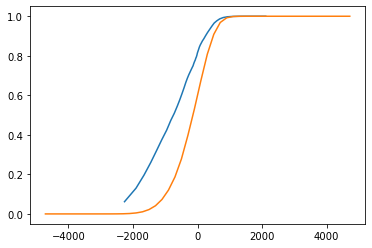

In [32]:
plt.plot(preds_cat_quant.z.mid_points, np.cumsum(preds_cat_quant.z.isel(time=0, lat=8, lon=16)))
plt.plot(preds_cat.z.mid_points, np.cumsum(preds_cat.z.isel(time=0, lat=8, lon=16)))

(array([  1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   1.,   2.,
          3.,   0.,   2.,   2.,   1.,   2.,   1.,   3.,   1.,   3.,   1.,
          4.,   1.,   5.,   6.,   4.,  10.,   7.,   8.,  11.,  10.,  18.,
         19.,  20.,  16.,  11.,  14.,   7.,  12.,  16.,  15.,  22.,  26.,
         23.,  24.,  30.,  39.,  63.,  55.,  60.,  64.,  69., 106., 121.,
        127., 101., 132., 132., 141.,  70.,  47.,  30.,  27.,  23.,  23.,
         23.,  20.,  19.,  17.,  16.,   9.,   8.,  18.,   7.,  12.,  11.,
          9.,  15.,  10.,   7.,   4.,   6.,   4.,   3.,   2.,   5.,   4.,
          2.,   4.,   2.,   3.,   3.,   1.,   1.,   2.,   4.,   1.,   0.,
          1.]),
 array([-3751.668   , -3683.6018  , -3615.5356  , -3547.4695  ,
        -3479.4033  , -3411.3372  , -3343.271   , -3275.2048  ,
        -3207.1387  , -3139.0725  , -3071.0063  , -3002.9402  ,
        -2934.874   , -2866.8076  , -2798.7415  , -2730.6753  ,
        -2662.6091  , -2594.543   , -2526.4768  , -2458.4106  

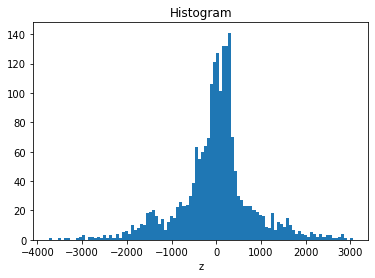

In [37]:
valid_diff.z.isel(time=-1).plot.hist(bins=100)

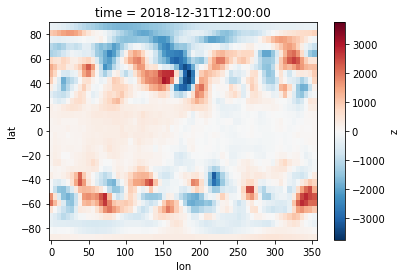

In [321]:
valid_diff.z.isel(time=-1).plot()

AttributeError: 'Dataset' object has no attribute 'tp'

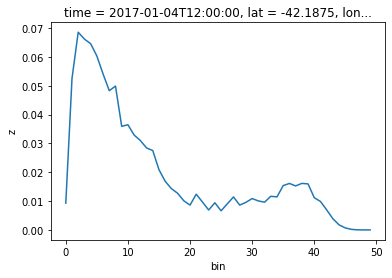

In [305]:
time = '2017-01-04T12:00:00'
preds_cat.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat.tp.sel(time=time).isel(lat=8, lon=16).plot()

### Old

In [17]:
cat_zt_preds=xr.merge([cat_quant_z_preds, cat_quant_t_preds]).rename({'z':'z_500','t':'t_850'})
cat_zt_preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z_500    (time, lat, lon, bin) float32 ...
    t_850    (time, lat, lon, bin) float32 ...

In [18]:
cat_zt_preds.z_500 # a little different time-number from parametric, dropout
#from values it seems that this is 'predict_difference' method

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [          -inf -2485.59762537 -2040.21876359 -1771.66673765...
    mid_points:  [          -inf -2262.90819448 -1905.94275062 -1658.69273963...
    bin_width:   inf

In [19]:
cat_zt_preds.z_500.isel(time=0,lat=0,lon=0).values.sum() #probabilities outputted

0.9999856

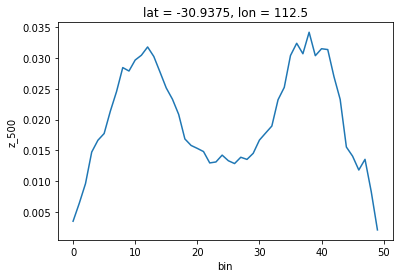

In [22]:
cat_zt_preds.z_500.isel(lat=10, lon=20).mean('time').plot() #bi-modal !!

In [23]:
#Valid data
zt_valid=xr.merge([z500_valid,t850_valid]).rename({'z':'z_500', 't':'t_850'})
zt_valid_diff = (zt_valid.shift() - zt_valid.shift(time=lead_time)).dropna('time')
zt_valid_diff #time size changes.

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>

In [24]:
#we should change -inf, inf to some finite values
cat_zt_preds.z_500.bin_edges[0]=zt_valid_diff.z_500.min().values
cat_zt_preds.z_500.bin_edges[-1]=zt_valid_diff.z_500.max().values
cat_zt_preds.t_850.bin_edges[0]=zt_valid_diff.t_850.min().values
cat_zt_preds.t_850.bin_edges[-1]=zt_valid_diff.t_850.min().values

cat_zt_preds.z_500.mid_points[0]=cat_zt_preds.z_500.bin_edges[1]-0.5*(cat_zt_preds.z_500.bin_edges[1]-cat_zt_preds.z_500.bin_edges[0])
cat_zt_preds.z_500.mid_points[-1]=cat_zt_preds.z_500.bin_edges[-2]+0.5*(cat_zt_preds.z_500.bin_edges[-1]-cat_zt_preds.z_500.bin_edges[-2])
cat_zt_preds.t_850.mid_points[0]=cat_zt_preds.t_850.bin_edges[1]-0.5*(cat_zt_preds.t_850.bin_edges[1]-cat_zt_preds.t_850.bin_edges[0])
cat_zt_preds.t_850.mid_points[-1]=cat_zt_preds.t_850.bin_edges[-2]+0.5*(cat_zt_preds.t_850.bin_edges[-1]-cat_zt_preds.t_850.bin_edges[-2])

#Ask- Unable to set bin-width as a  (50,1) array. doesnt matter. doesnt impact crps calculation.one solution is to take first and last bins as uniform and not min/max
#cat_zt_preds.z_500.bin_width=(cat_zt_preds.z_500.bin_edges[1:]-cat_zt_preds.z_500.bin_edges[:-1])

In [25]:
cat_zt_preds.z_500

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [-7.29664062e+03 -2.48559763e+03 -2.04021876e+03 -1.77166674...
    mid_points:  [-4.89111913e+03 -2.26290819e+03 -1.90594275e+03 -1.65869274...
    bin_width:   inf

In [26]:
#For RMSE1- most likely class. But we lose all probability info.
# Using bin mid_points of prediction with highest probability
das = []
for var in ['z_500', 't_850']:
    idxs = np.argmax(cat_zt_preds[var], -1)
    most_likely = cat_zt_preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [cat_zt_preds.time, cat_zt_preds.lat, cat_zt_preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)
preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -548.5 -548.5 ... -1.447e+03 -1.447e+03
    t_850    (time, lat, lon) float64 -1.057 -1.731 -1.731 ... -6.546 -9.288

In [27]:
preds_ml.z_500.mean().values, zt_valid_diff.z_500.mean().values

(array(-154.42724882), array(-0.6240898, dtype=float32))

In [28]:
zt_cat_rmse=compute_weighted_rmse(preds_ml, zt_valid_diff.sel(time=preds_ml.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 619.2
    t_850    float64 4.586

In [29]:
#Correct way. RMSE= ∑xP
aa=preds_ml.z_500.isel(time=0, lat=0,lon=0); print(aa.values)

ab=cat_zt_preds.z_500.isel(time=0, lat=0, lon=0);ab.values
ac=cat_zt_preds.z_500.mid_points; ac
ad=ab*ac; ad
ad.sum().values

-548.5331986033314


array(-467.04123775)

In [31]:
#Ask- Unable to run full. kernel dies.
preds=cat_zt_preds.isel(time=slice(0,20))
ensemble_mean=xr.Dataset()

z_500_ensemble=(preds.z_500*preds.z_500.mid_points).sum('bin')
t_850_ensemble=(preds.t_850*preds.t_850.mid_points).sum('bin')

ensemble_mean['z_500']=z_500_ensemble
ensemble_mean['t_850']=t_850_ensemble
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -467.0 -508.0 ... -1.654e+03 -1.645e+03
    t_850    (time, lat, lon) float64 -0.281 -0.5851 -0.8576 ... -1.554 -1.21

In [32]:
zt_cat_rmse=compute_weighted_rmse(ensemble_mean, 
                                 zt_valid_diff.sel(
                                     time=ensemble_mean.time)).load()
zt_cat_rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 454.4
    t_850    float64 2.962

In [33]:
compute_weighted_rmse(preds_ml.isel(time=slice(0,20)),zt_valid_diff.isel(time=slice(0,20))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 586.6
    t_850    float64 3.974

In [46]:
#Correct RMSE= ∑xP
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [34]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
preds=cat_zt_preds.isel(time=slice(0,20))


obs=zt_valid_diff.sel(time=preds.time)
predssquare=preds
predssquare.z_500.attrs['mid_points']=preds.z_500.attrs['mid_points']*preds.z_500.attrs['mid_points']
predssquare.t_850.attrs['mid_points']=preds.t_850.attrs['mid_points']*preds.t_850.attrs['mid_points']

In [35]:
#predssquare.z_500

In [36]:
#Ask- Unable to run full. kernel dies.
ensemble_meansquare=xr.Dataset()
z_500_ensemble=(predssquare.z_500*predssquare.z_500.mid_points).sum('bin')
t_850_ensemble=(predssquare.t_850*predssquare.t_850.mid_points).sum('bin')

ensemble_meansquare['z_500']=z_500_ensemble
ensemble_meansquare['t_850']=t_850_ensemble
#ensemble_meansquare

In [37]:
#Spread
var1=ensemble_meansquare-ensemble_mean*ensemble_mean #Wrong. has -ve t values
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
zt_cat_spread= np.sqrt((var1*weights_lat).mean())
zt_cat_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 487.9
    t_850    float64 2.529

In [38]:
#Spread-skill
z_cat_spreadskill=zt_cat_spread/zt_cat_rmse
z_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 1.074
    t_850    float64 0.8541

In [39]:
# # Bin CRPS
obs=zt_valid_diff.sel(time=cat_zt_preds.time)
preds=cat_zt_preds
zt_cat_bin_crps=compute_weighted_bin_crps(preds, obs)
zt_cat_bin_crps.load() #WRONG. Can't be negative.

100%|██████████| 175/175 [01:55<00:00,  1.52it/s]


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 188.3
    t_850    float64 -0.01537

In [40]:
#Rank Histogram
member=20
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)

z_bin_mids=preds.z_500.mid_points
t_bin_mids=preds.t_850.mid_points
preds_z=np.asarray(preds.z_500).reshape(-1,50)
preds_t=np.asarray(preds.t_850).reshape(-1,50)

preds_znew=[]
preds_tnew=[]
for i, p in enumerate(preds_z):
    prob_z=preds_z[i,:]; prob_t=preds_t[i,:]
    prob_z /= prob_z.sum();prob_t /= prob_t.sum()  #normalizing. bcoz sometimes prob doesn't equal exactly 1.
    sample_z=np.random.choice(z_bin_mids, size=member, p=preds_z[i,:],replace=True)
    sample_t=np.random.choice(t_bin_mids, size=member, p=preds_t[i,:],replace=True)
    preds_znew.append(sample_z)
    preds_tnew.append(sample_t)
    
preds_znew=np.array(preds_znew).reshape(member, -1)
preds_tnew=np.array(preds_tnew).reshape(member, -1)

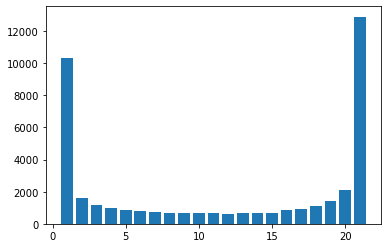

In [41]:
#Rank Histogram
from ranky import rankz
obs_z=obs.z_500.values.reshape(-1)
#for z_500
mask=np.ones(obs_z.shape) #useless. #masked where 0/false.
result = rankz(obs_z, preds_znew, mask)
plt.bar(range(1,preds_znew.shape[0]+2), result[0])
plt.show()

In [27]:
#for all

# create dropout ensemble testing

In [8]:
!ls {pred_save_dir}

001-resnet_d3_ztt_3d_dr0.0.nc	  010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m2.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	  021-resnet_d3_tp_3d_dr0.2.nc
004-resnet_d3_ztt_3d_dr0.5_m2.nc  021-resnet_d3_tp_3d_dr0.2_m2.nc
005-resnet_d3_ztt_3d_param.nc	  022-resnet_d3_tp_3d_dr0.5.nc
006-resnet_d3_z_3d_cat.nc	  saved_models
007-resnet_d3_t_3d_cat.nc


In [9]:
import tqdm
from tqdm import tqdm
#Somehow .py script doesn't run, but copying code here in notebook works.
#works for ztt, not for tp

In [10]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml'
    ensemble_size=2; old_const=False; no_mean=False; multi_dt=False; verbose=0
    no_mean=True; #for precipitation
    args=load_args(exp_id_path)
    args['model_save_dir']=model_save_dir
    args['pred_save_dir']=pred_save_dir
    args['datadir']=datadir

    args['ext_mean'] =xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
    args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')
    dg=load_data(**args, old_const=old_const, only_test=True)

    #tf.compat.v1.disable_eager_execution() #needed
    
    model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 
                   'lat_mse': tf.keras.losses.mse})
    #adding dropout
    c = model.get_config()
    for l in c['layers']:
        if l['class_name'] == 'Dropout':
            l['inbound_nodes'][0][0][-1] = {'training': True}
    
    model2 = keras.models.Model.from_config(c, custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 'lat_mse': tf.keras.losses.mse})
    model2.set_weights(model.get_weights())
            
    
    level_names = dg.data.isel(level=dg.output_idxs).level_names
    level = dg.data.isel(level=dg.output_idxs).level
    
    preds = []
    for _ in tqdm(range(ensemble_size)):
        #preds.append(model2.predict(dg.tfr_dataset or dg, verbose=verbose))
        preds.append(model2.predict(dg, verbose=verbose))
    

    
    preds = np.array(preds)
    

    preds = xr.DataArray(
        preds[0] if multi_dt else preds,
        dims=['member','time', 'lat', 'lon', 'level'],
        coords={'member':np.arange(ensemble_size),'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': level,
                'level_names': level_names
                },
    )
    # Unnormalize
    mean = dg.mean.isel(level=dg.output_idxs).values if not no_mean else 0
    std = dg.std.isel(level=dg.output_idxs).values
    preds = preds * std + mean
    #print(mean)
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

    # Reverse tranforms
    if hasattr(dg.mean, 'tp_log') and 'tp' in unique_vars:
        tp_idx = list(preds.level_names).index('tp')
        preds.values[..., tp_idx] = log_retrans(preds.values[..., tp_idx], dg.mean.tp_log)

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] == v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    preds=xr.merge(das)
    
    preds.to_netcdf(f'{args["pred_save_dir"]}/{args["exp_id"]}_m{ensemble_size}.nc')
    print(f'saved on disk in {args["pred_save_dir"]}/{args["exp_id"]}_m{ensemble_size}.nc')


  0%|          | 0/2 [00:00<?, ?it/s]


StopIteration: 

In [13]:
exp_id='004-resnet_d3_ztt_3d_dr0.5_2'
preds1=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [14]:
preds1

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17436)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (member, time, lat, lon) float64 ...
    z        (member, time, lat, lon) float64 ...
    t        (member, time, lat, lon) float64 ...

# Plots

In [ ]:
t2m_valid.t2m.isel(lat=10, lon =30).plot()